# Setup environment

In [ ]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [ ]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/twitter-suicidal-data.csv')

## Data Preprocessing

In [ ]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def convert_emoji_to_text(text):
    """This function converts emojis to their text descriptions."""
    return emoji.demojize(text, delimiters=(" ", " "))

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Remove usernames
    text = re.sub(r'@\w+', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert emojis to text
    text = convert_emoji_to_text(text)

    # Remove non-word characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # POS tagging and lemmatization
    pos_tagged = nltk.pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, pos=nltk_pos_tagger(tag)) for word, tag in pos_tagged]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    return tokens

### Questions

#### Lowercase Conversion

Pros:
1. **Consistency**: Converting all characters to lowercase ensures uniformity in the dataset, making it easier to process and analyze.
2. **Reduction of Vocabulary Size**: Lowercasing reduces the number of unique tokens in the dataset, which can improve computational efficiency.
3. **Improved Generalization**: Lowercasing helps in generalizing text data by treating words regardless of their case, which can be beneficial for tasks like sentiment analysis or text classification.

Cons:
1. **Loss of Information**: Converting to lowercase may result in the loss of information, especially for proper nouns or acronyms where case sensitivity matters.
2. **Ambiguity**: Some words have different meanings or contexts based on their case. Lowercasing can introduce ambiguity in such cases.
3. **Dependency on Language**: Lowercasing may not be suitable for all languages, where case holds semantic significance. For example, German nouns are capitalized, and lowercasing them could change the meaning.


Despite these drawbacks, lowercasing is often performed in text preprocessing for its benefits in simplifying text representation and improving generalization across different tasks and datasets. It's typically applied judiciously, with consideration given to the specific characteristics and requirements of the text data and the downstream tasks involved.

#### Removing Numbers

Pros:
1. **Improved Text Clarity**: Removing numbers from tweets can enhance the readability and interpretability of the text, especially if the numbers are not relevant to the context.
2. **Reduction of Noise**: Numbers often represent noise in text data, particularly in social media posts like tweets, where they might include timestamps, user IDs, or irrelevant numerical values.
3. **Focus on Textual Content**: Eliminating numbers allows the focus to be on the textual content of the tweets, which is usually more informative for natural language processing tasks.

Cons:
1. **Loss of Context**: Numbers in tweets can sometimes carry valuable information, such as statistics, measurements, or quantities, which may be relevant for certain analysis tasks.
1. **Altered Meaning**: Removing numbers can alter the meaning or context of the tweet, especially if the numbers are integral to understanding the message or sentiment conveyed.
3. **Impact on Entities**: Deleting numbers might affect the recognition of entities such as dates, times, or numerical references, which could be important for downstream tasks like event detection or sentiment analysis.

#### Removing Hashtags

Pros:
1. **Improved Readability**: Removing hashtags from tweets can enhance readability, especially if they are overly abundant or distracting.
2. **Focus on Textual Content**: Eliminating hashtags allows the focus to be on the actual text of the tweet, which is typically more relevant for natural language processing tasks.
3. **Reduction of Noise**: Hashtags can sometimes introduce noise into the text data, particularly if they are used excessively or irrelevantly, and removing them can help mitigate this issue.

Cons:
1. **Loss of Context**: Hashtags often provide valuable context or metadata about the content of the tweet, including topics, events, or communities, and deleting them can lead to a loss of this information.
2. **Altered Meaning**: Removing hashtags can alter the meaning or tone of the tweet, especially if the hashtags are integral to understanding the message or sentiment conveyed.
3. **Impact on Analysis**: Deleting hashtags can affect the analysis of the tweet data, particularly for tasks like topic modeling or trend analysis, where hashtags serve as important features for classification or clustering.

In [ ]:
print("BEFORE:")
print(data.iloc[0]['tweet'])
print("-------\nAFTER:")
preprocess_data(data.iloc[0]['tweet'])

BEFORE:
my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
-------
AFTER:


['life',
 'meaningless',
 'want',
 'end',
 'life',
 'badly',
 'life',
 'completely',
 'empty',
 'dont',
 'want',
 'create',
 'meaning',
 'create',
 'meaning',
 'pain',
 'long',
 'hold',
 'back',
 'urge',
 'run',
 'car',
 'head',
 'first',
 'next',
 'person',
 'come',
 'opposite',
 'way',
 'stop',
 'feel',
 'jealous',
 'tragic',
 'character',
 'like',
 'gomer',
 'pile',
 'swift',
 'end',
 'able',
 'bring',
 'life']

In [ ]:
print("BEFORE:")
print(data.iloc[1]['tweet'])
print("-------\nAFTER:")
preprocess_data(data.iloc[1]['tweet'])

BEFORE:
muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels 
-------
AFTER:


['mutter',
 'wan',
 'na',
 'die',
 'daily',
 'month',
 'feel',
 'worthless',
 'shes',
 'soulmate',
 'cant',
 'live',
 'horrible',
 'world',
 'without',
 'lonely',
 'wish',
 'could',
 'turn',
 'part',
 'brain',
 'feel']

In [ ]:
data['processed_tweet'] = data['tweet'].apply(preprocess_data)

data['num_tokens'] = data['processed_tweet'].apply(len)

<ipython-input-12-2bed29f58969>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='intention', y='num_tokens', data=data_plot, palette="Set2", meanprops=meanprops, showmeans=True)


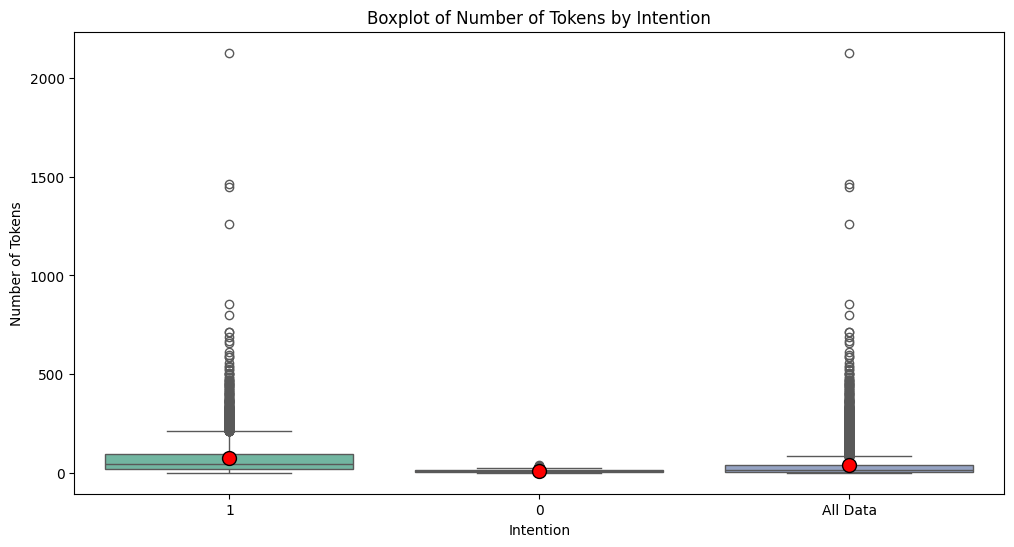

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data_all = data.copy(deep=True)
data_all['intention'] = 'All Data'

data_plot = pd.concat([data, data_all])
meanprops = dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=10)

plt.figure(figsize=(12, 6))
sns.boxplot(x='intention', y='num_tokens', data=data_plot, palette="Set2", meanprops=meanprops, showmeans=True)

plt.title('Boxplot of Number of Tokens by Intention')
plt.xlabel('Intention')
plt.ylabel('Number of Tokens')
plt.show()

<ipython-input-13-5899fae64912>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='intention', y='num_tokens', data=data_plot_filtered, palette="Set2", meanprops=meanprops, showmeans=True)


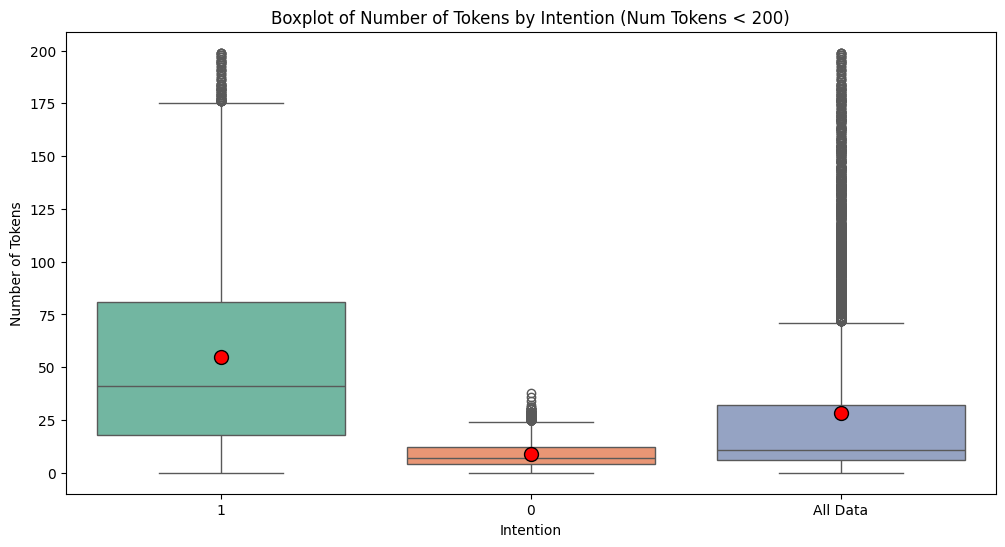

In [ ]:
data_filtered = data[data['num_tokens'] < 200]

data_all_filtered = data_filtered.copy()
data_all_filtered['intention'] = 'All Data'

data_plot_filtered = pd.concat([data_filtered, data_all_filtered])

plt.figure(figsize=(12, 6))
meanprops = dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=10)

sns.boxplot(x='intention', y='num_tokens', data=data_plot_filtered, palette="Set2", meanprops=meanprops, showmeans=True)

plt.title('Boxplot of Number of Tokens by Intention (Num Tokens < 200)')
plt.xlabel('Intention')
plt.ylabel('Number of Tokens')
plt.show()

In [ ]:
# data = data.drop(columns=['processed_tweet', 'num_tokens'])
data

,tweet,intention,processed_tweet,num_tokens
0,my life is meaningless i just want to end my l...,1,"[life, meaningless, want, end, life, badly, li...",42
1,muttering i wanna die to myself daily for a fe...,1,"[mutter, wan, na, die, daily, month, feel, wor...",22
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif...",32
3,i did something on the 2 of october i overdose...,1,"[something, october, overdose, felt, alone, ho...",29
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, care, want, die, maybe, feel...",10
...,...,...,...,...
9114,have you ever laid on your bed at night and cr...,1,"[ever, lay, bed, night, cry, good, enough, cou...",14
9115,the fault the blame the pain s still there i m...,1,"[fault, blame, pain, still, alone, inside, bro...",10
9116,stop asking me to trust you when i m still cou...,1,"[stop, ask, trust, still, cough, water, last, ...",10
9117,i never know how to handle sadness crying make...,1,"[never, know, handle, sadness, cry, make, feel...",8


# Word2Vec - Word Embedding

In [ ]:
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
W2V_PATH = './w2v' # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.

Saving Word2Vec model...
Word2Vec model is saved.


In [ ]:
W2V_PATH = './w2v'
w2v_model.save(W2V_PATH)

In [ ]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

#### Handling Out-of-Vocabulary (OOV) Words

1. **Default Zero-Vector:**
    - **Pros**:
        - **Simplicity:** Easy to implement, requiring minimal additional processing.
        - **Consistency:** Ensures that all OOV words have the same vector representation, maintaining uniform vector dimensions across the dataset.
        - **Avoids Noise:** Unlike random vectors, zero-vectors do not introduce noise into the model.

    - **Cons**:
        - **Loss of Information:** Zero-vectors carry no semantic information, which means the model loses the potential contextual meaning of the OOV words.
        - **Bias Towards Known Words:** The model might overly rely on known words, as OOV words contribute nothing to the feature space.
        - **Potential for Misleading Results:** In some cases, having too many zero-vectors can make sentences appear artificially similar, which might mislead the model during training.


2. **Ignore OOV Words**
    - **Pros:**
        - **Simplicity:** Easy to implement, with no additional processing required.
        - **Efficiency:** Reduces computational load by not processing unknown words.

    - **Cons:**
        - **Loss of Information:** May lose important contextual information.
        - **Incomplete Context:** Sentences with many OOV words might become less meaningful.


3. **Use a Random Vector**
Generate a random vector for OOV words.

    - **Pros:**
        - **Continuity:** Maintains vector size consistency for all words.
        - **Diversity:** Random vectors might help models to generalize.

    - **Cons:**
        - **Inconsistency:** Random vectors lack semantic meaning and consistency.
        - **Model Instability:** Introduces noise, which can degrade model performance.


4. **Use a Special Token**
Replace OOV words with a special token (e.g., `<UNK>`).

    - **Pros:**
        - **Simplicity:** Easy to implement and understand.
        - **Consistency:** Ensures consistent handling of all OOV words.

    - **Cons:**
        - **Loss of Specificity:** Treats all OOV words the same, losing specific contextual meaning.
        - **Contextual Disruption:** Frequent `<UNK>` tokens can disrupt the context.


5. **Subword Embeddings**
Use subword information to generate embeddings (e.g., FastText).

    - **Pros:**
        - **Coverage:** Handles many OOV words by breaking them into subwords.
        - **Semantic Consistency:** Provides meaningful embeddings based on subword structure.

    - **Cons:**
        - **Complexity:** More complex to implement compared to simple word vectors.
        - **Performance Overhead:** Slightly more computationally intensive.

# Dataset

In [ ]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        # Convert tokens to their corresponding word vectors
        vectors = []
        for token in tokens:
            # print(token, type(token))
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append([0] * self.vector_size)
        return torch.tensor(vectors, dtype=torch.float)


    def _pad(self, tokens: list):
        # Add paddings (zero-vectors) into the end of sequence to reach the desired length
        padded_tokens = tokens[:self.max_sequence_len]
        # print(tokens, type(tokens))
        if len(padded_tokens) < self.max_sequence_len:
            padded_tokens.extend([0] * (self.max_sequence_len - len(padded_tokens)))
        return padded_tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

## Create Datasets

In [ ]:
train_data['tweet'].iloc[0]


'am i wrong my now ex boyfriend broke up with me so that he can figure life out he was the only reason i liked being alive he was my flame i had something to look forward to i had a reason to improve myself without him i have no desire to live no desire to improve myself i have nothing i get that it is unfair to him but i cant help that i cant find any internal motivations to live i just dont know what to do and i dont know what will happen if he doesnt come back '

In [ ]:
sequence_len = 64

train_dataset = Twitter(
    train_data,
    w2v_model,
    sequence_len
)
test_dataset = Twitter(
    test_data,
    w2v_model,
    sequence_len
)
print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")
# print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 30


<ipython-input-19-3c15f66c9c2c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-19-3c15f66c9c2c>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(vectors, dtype=torch.float)
<ipython-input-19-3c15f66c9c2c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Deleted 0-Len Samples: 7


<ipython-input-19-3c15f66c9c2c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Train dataset length: 8177
Test dataset length: 905


<ipython-input-19-3c15f66c9c2c>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [ ]:
sequence_len = 196

train_dataset_2 = Twitter(
    train_data,
    w2v_model,
    sequence_len
)
test_dataset_2 = Twitter(
    test_data,
    w2v_model,
    sequence_len
)

# Model and Train

## Utils

In [ ]:
@torch.no_grad()
def model_eval(
        model,
        loader,
        loss_function,
        device: str = 'auto'
):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total_samples = 0
    correct_samples = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=True)

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_samples += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        test_acc = correct_samples / total_samples

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )
    test_loss /= len(itr)
    return test_loss, test_acc


In [ ]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        test_set,
        device: str = 'auto',
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # itr = tqdm(train_loader, total=len(train_loader), leave=False)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        epoch_correct = 0
        epoch_total = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=True, desc=f"(Training) Epoch [{epoch + 1}/{epochs}]")

        for idx, (inputs, labels) in enumerate(itr, start=1):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_total += labels.size(0)
            epoch_acc = epoch_correct / epoch_total

            # Calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc, 5),
            )

        epoch_loss /= len(itr)

        model.eval()

        test_loss, test_acc = model_eval(
            model=model,
            loader=test_loader,
            loss_function=loss_function,
            device=device
        )

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)


    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "test_loss": test_losses,
      "test_acc": test_accs,
    }
    return history

In [ ]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [ ]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    true_labels = []
    predicted_labels = []

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    cm = metrics.confusion_matrix(
        y_true=true_labels,
        y_pred=predicted_labels,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
    f1 = metrics.f1_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
    precision = metrics.precision_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, context=64, reg=False):
        super(CNN, self).__init__()
        self.reg = reg
        # # Layer 1
        self.conv1_3 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=context, out_channels=64, kernel_size=7, padding=3)

        # Batch Normalization layer
        self.bn1_3 = nn.BatchNorm1d(64)
        self.bn1_5 = nn.BatchNorm1d(64)
        self.bn1_7 = nn.BatchNorm1d(64)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Layer 2
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)


        # Batch Normalization layer
        self.bn2_3 = nn.BatchNorm1d(128)
        self.bn2_5 = nn.BatchNorm1d(128)
        self.bn2_7 = nn.BatchNorm1d(128)

        # Max Pooling layer after the second convolutional layer
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Layer 1
        x1_3 = F.relu(self.conv1_3(x))
        x1_5 = F.relu(self.conv1_5(x))
        x1_7 = F.relu(self.conv1_7(x))

        if (self.reg):
          x1_3 = self.dropout(x1_3)
          x1_5 = self.dropout(x1_5)
          x1_7 = self.dropout(x1_7)

        # Layer 2
        x2_3 = None
        x2_5 = None
        x2_7 = None

        if (self.reg):
          x2_3 = F.relu(self.bn2_3(self.conv2_3(x1_3)))
          x2_5 = F.relu(self.bn2_5(self.conv2_5(x1_5)))
          x2_7 = F.relu(self.bn2_7(self.conv2_7(x1_7)))

        else:
          x2_3 = F.relu(self.conv2_3(x1_3))
          x2_5 = F.relu(self.conv2_5(x1_5))
          x2_7 = F.relu(self.conv2_7(x1_7))

        if (self.reg):
          x2_3 = self.dropout(x2_3)
          x2_5 = self.dropout(x2_5)
          x2_7 = self.dropout(x2_7)

        # Apply max pooling after the second convolutional layers
        x2_3 = self.maxpool(x2_3)
        x2_5 = self.maxpool(x2_5)
        x2_7 = self.maxpool(x2_7)

        # Apply global average pooling
        x2_3 = self.global_avg_pool(x2_3)
        x2_5 = self.global_avg_pool(x2_5)
        x2_7 = self.global_avg_pool(x2_7)

        # Concatenate the outputs of layer 2 convolutional layers along the channel dimension
        x = torch.cat((x2_3, x2_5, x2_7), dim=1)

        # Flatten layer
        x = self.flatten(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Output layer (no activation, as we'll apply softmax in the loss function)
        return x


## Training

### Window-Context = 64 ; Regularization = False

In [ ]:
model = CNN(64)

batch_size = 32
num_epochs = 10

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

cnn_model_train_history = train_model(
    model=model,
    batch_size=batch_size,
    loss_function=criterion,
    optimizer=optimizer,
    epochs=num_epochs,
    train_set=train_dataset,
    test_set=test_dataset
)

(Eval): 100%|██████████| 29/29 [00:00<00:00, 74.37it/s, accuracy=0.843, loss=1.12]


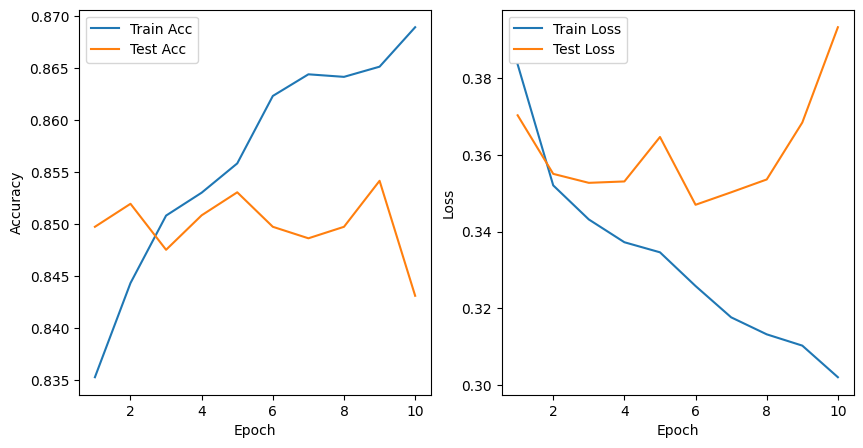

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Test Acc", cnn_model_train_history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Test Loss", cnn_model_train_history["test_loss"])
        ]
    }
)

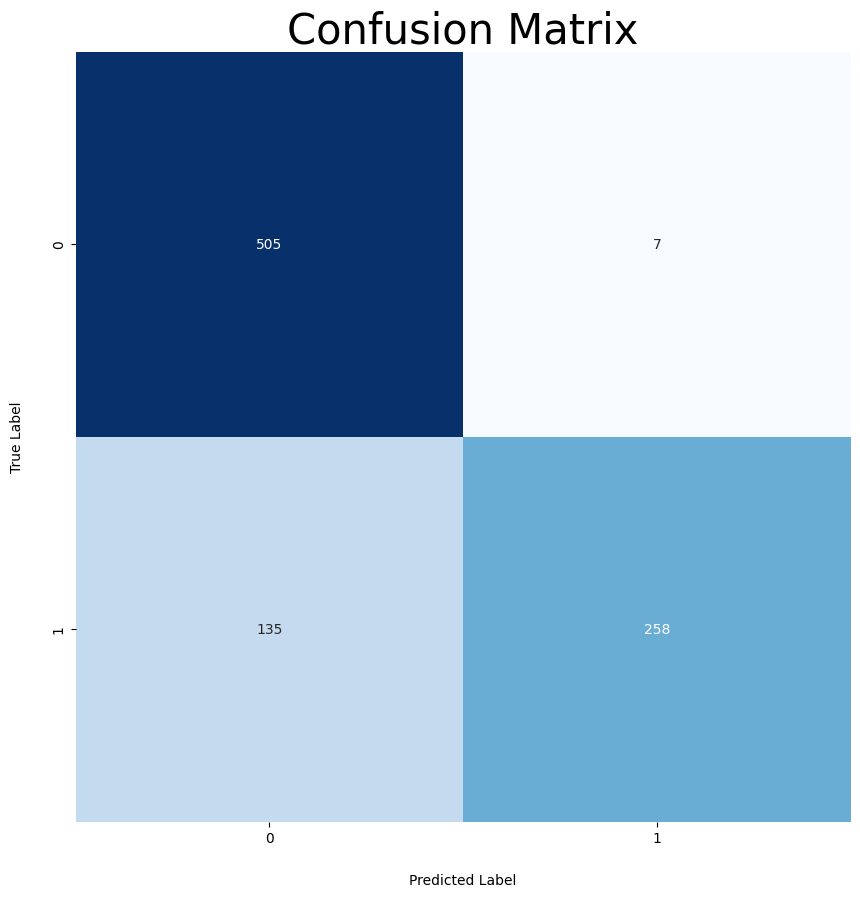

In [ ]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=test_dataset,
)

In [ ]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.821
F1:        0.830
Precision: 0.881
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       512
           1       0.97      0.66      0.78       393

    accuracy                           0.84       905
   macro avg       0.88      0.82      0.83       905
weighted avg       0.87      0.84      0.84       905



#### SGD vs. Adam


- **SGD**: It is a simple optimization algorithm that updates the weights based on the gradient of the loss function with respect to the weights. It computes the gradient on a small batch of training data and updates the weights in the direction of the negative gradient.

- **Adam**: Adam is a more complex optimization algorithm that combines the ideas of momentum and adaptive learning rates. It computes an exponentially weighted average of the past gradients and the past squared gradients and uses them to update the weights. This helps to smooth out the noise in the gradient, which can make the optimization more stable. Additionally, Adam adapts the learning rate for each weight based on the estimates of the variance and the mean of the gradients, which can help to converge faster and avoid getting stuck in local minima.

In summary, **SGD** is a simple and widely used optimization algorithm, but it can be slow to converge and sensitive to the choice of learning rate.

**Adam**, on the other hand, is a more complex and computationally expensive algorithm, but it can converge faster and adaptively adjust the learning rate based on the gradient's statistics.

#### Why Cross Entropy

Cross-entropy loss is commonly used in classification tasks, including text classification problems such as identifying the intention to commit suicide from tweets. Here are the reasons why cross-entropy loss is particularly suitable for this type of problem:

**Reasons for Using Cross-Entropy Loss**:

1. **Probabilistic Interpretation**:
   - Cross-entropy loss measures the performance of a classification model whose output is a probability value between 0 and 1. In the context of classifying tweets for suicidal intent, the model's output can be interpreted as the probability that a tweet indicates suicidal intent.

2. **Effective Gradient Computation**:
   - Cross-entropy loss works well with gradient-based optimization methods like those used in training convolutional neural networks (CNNs). It provides clear and effective gradients that help the model converge more efficiently during training.

3. **Penalizing Incorrect Predictions**:
   - Cross-entropy loss penalizes incorrect classifications more heavily than some other loss functions. For a sensitive issue like suicide intent detection, this is important because it encourages the model to make accurate predictions, reducing the risk of false negatives (failing to identify actual suicidal intent).

4. **Handling Multiple Classes**:
   - If the problem involves more than two classes (e.g., different levels of suicidal intent or multiple intentions including non-suicidal ones), cross-entropy loss can easily extend to multi-class classification using softmax activation in the output layer.

Given the sensitive nature of detecting suicidal intent in tweets, cross-entropy loss helps ensure the model's predictions are both probabilistically meaningful and optimized effectively, making it a suitable choice for this classification task.

#### Splitting Data

Splitting the data with `90%` for training and `10%` for testing is a common practice because it provides a good balance between having enough data to train the model effectively (8100 tweets) while retaining a sufficient amount of data to evaluate the model's performance (900 tweets). This ensures that the model can learn from a large dataset and still be validated on a separate set to check for generalization and potential overfitting.

#### Kernel Size

The kernel size in convolutional layers is a critical hyperparameter that influences how the model extracts features from the input data.

**Effect of Kernel Size:**
1. **Receptive Field**:
   - The kernel size determines the receptive field of the convolutional layer, which is the area of the input that the kernel "sees" at each convolution step.

2. **Feature Detection**:
   - Smaller kernels (e.g., 3x3): Capture fine-grained details and local patterns. Useful for detecting small and detailed features.
   - Larger kernels (e.g., 7x7 or larger): Capture broader and more complex patterns. Useful for detecting larger structures and more abstract features.

**How It Helps in Feature Extraction:**
1. **Local Features**:
   - Smaller kernels are effective in capturing local features such as edges, textures, and small shapes. This is because they focus on a smaller region of the input, allowing the model to detect fine details.

2. **Global Features**:
   - Larger kernels can capture more global features and context within the image or text. They consider a wider area, which can be beneficial for recognizing larger patterns or more contextual information.

**Implications of Low or High Kernel Size:**
- **Low Kernel Size (e.g., 3x3, 5x5)**:
  - **Pros**:
    - More granular feature extraction.
    - Often results in more layers, which can lead to deeper hierarchical feature representation.
    - Computationally efficient as they involve fewer parameters.
  - **Cons**:
    - Might miss larger contextual information if not used in deeper networks.

- **High Kernel Size (e.g., 7x7, 11x11)**:
  - **Pros**:
    - Can capture more context and larger patterns in a single layer.
    - Useful for higher-level feature extraction, such as detecting shapes or textures in images or broader phrases in text.
  - **Cons**:
    - Higher computational cost due to more parameters.
    - Risk of overfitting if the kernel size is too large relative to the input size.
    - May result in less detailed local feature extraction.


#### Feed Forward Layers for Dimensionality Reduction

Feedforward layers, often referred to as fully connected layers or dense layers, are layers in which each neuron is connected to every neuron in the previous layer. These layers perform a linear transformation followed by a non-linear activation function.
```python
# Feedforward layers (Fully Connected layers)
self.fc1 = nn.Linear(3 * 128, 128)  # First feedforward layer
self.fc2 = nn.Linear(128, 1)        # Second feedforward layer (output layer for binary classification)
```

1. **Preservation of Spatial Information**:
   - **Pros**: Maintains spatial relationships and detailed features.
   - **Comparison**: Pooling can lose fine-grained features early.

2. **Flexible Feature Representation**:
   - **Pros**: Fully connected layers learn the most relevant feature combinations.
   - **Comparison**: Pooling methods are fixed and non-learnable.

3. **Increased Model Capacity**:
   - **Pros**: Enhances ability to learn complex patterns.
   - **Comparison**: Pooling limits parameter count and complexity.

4. **Control Over Dimensionality Reduction**:
   - **Pros**: Allows precise and gradual reduction of dimensions.
   - **Comparison**: Pooling reduces dimensions by fixed ratios, limiting control.

In summary, using feed forward layers after convolutional layers offers greater flexibility, control, and capacity for learning complex features compared to pooling methods.

#### Batch Size Effect

**Batch Size Impact:**
- **High Initial Performance**: Our model metrics were already high.
- **Little Difference**: Using different batch sizes (32, 16, 64) showed minimal impact on performance.

**Insights:**
- **Stability of Metrics**: High initial performance indicates that the model is robust across various batch sizes.
- **Minor Variations**: Small performance changes suggest the model is not highly sensitive to batch size in this context.

In conclusion, different batch sizes had little effect because the model was already performing well and was robust to these changes.

### Window-Context = 196 ; Regularization = False

In [ ]:
model_2 = CNN(196)

batch_size = 128
num_epochs = 10

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_2.parameters(), lr=0.03)

# Training history
cnn_model_train_history2 = train_model(
    model=model_2,
    batch_size=batch_size,
    loss_function=criterion,
    optimizer=optimizer,
    epochs=num_epochs,
    train_set=train_dataset_2,
    test_set=test_dataset_2
)

(Eval): 100%|██████████| 8/8 [00:00<00:00, 21.86it/s, accuracy=0.882, loss=0.34]


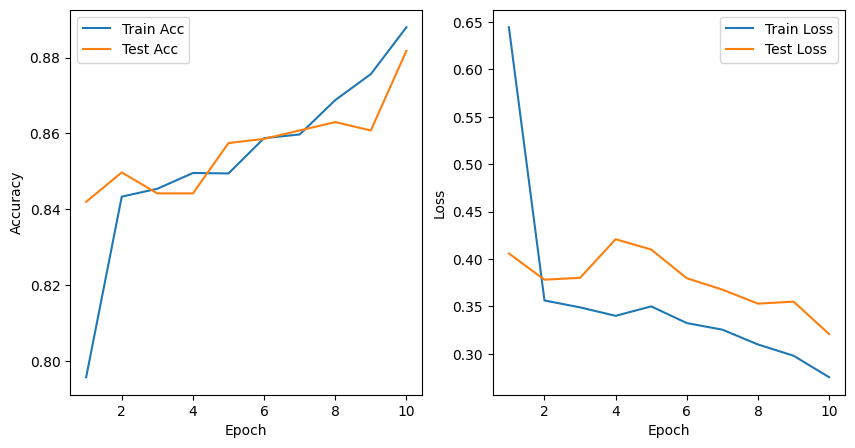

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history2["train_acc"]),
            ("Test Acc", cnn_model_train_history2["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history2["train_loss"]),
            ("Test Loss", cnn_model_train_history2["test_loss"])
        ]
    }
)

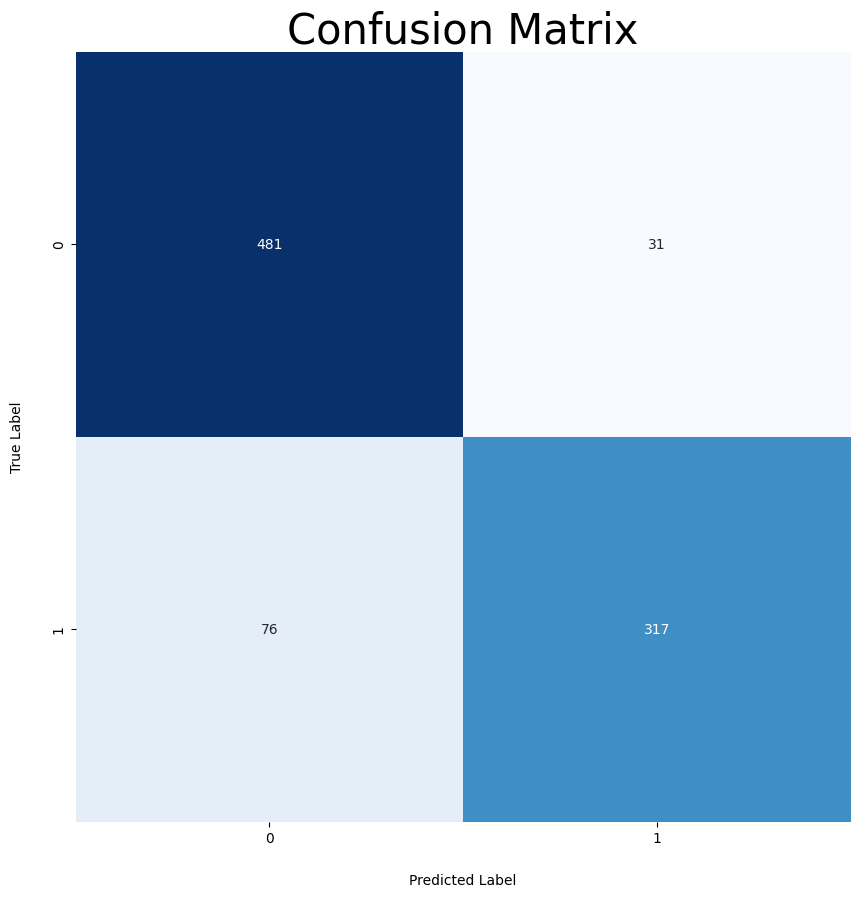

In [ ]:
cnn_model_report2 = generate_confusion_matrix(
    model=model_2,
    dataset=test_dataset_2,
)

In [ ]:
print(f"Recall:    {cnn_model_report2['recall']:.3f}")
print(f"F1:        {cnn_model_report2['f1']:.3f}")
print(f"Precision: {cnn_model_report2['precision']:.3f}")
print(cnn_model_report2['report'])

Recall:    0.873
F1:        0.878
Precision: 0.887
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       512
           1       0.91      0.81      0.86       393

    accuracy                           0.88       905
   macro avg       0.89      0.87      0.88       905
weighted avg       0.88      0.88      0.88       905



#### Setting the Context-Window Larger than the Length of All Tweets

**Pros:**
1. **Global Context Capture**:
   - **Pros**: The CNN can consider the entire tweet, capturing all available context and nuances, which can be beneficial for understanding the complete meaning.
   - **Benefit**: Ensures that no information is lost due to window limitations, potentially improving model performance on tasks requiring full context understanding.

2. **Simpler Model Configuration**:
   - **Pros**: No need to fine-tune the context window size for varying tweet lengths, simplifying preprocessing and model configuration.
   - **Benefit**: Uniformity in data processing, making the implementation and maintenance of the model more straightforward.

**Cons:**
1. **Computational Inefficiency**:
   - **Cons**: Processing unnecessary padding can increase computational load and memory usage without adding meaningful information.
   - **Drawback**: Slower training and inference times, as the model processes additional, non-informative data.

2. **Potential Overfitting**:
   - **Cons**: The model might overfit to the specific structure and length of the padded tweets, learning to recognize padding patterns instead of focusing solely on meaningful content.
   - **Drawback**: Reduced generalization to tweets of different lengths or formats.

3. **Dilution of Important Features**:
   - **Cons**: Important features might be diluted by the inclusion of many padding tokens, potentially leading to reduced model sensitivity to key words and phrases.
   - **Drawback**: Lower model accuracy and effectiveness, particularly for shorter tweets where padding dominates the input.

#### Comparision

We can see that we got better result metrics, especially in `intention = 1`. We got 15 percent a recall better.

It shows that despite the fact that the bigger window context brings us more computational cost, it also makes the model perform better.

Also regrading the plots, we can see that with `window context = 64` we may have been overfitting, as the loss of the test data increases, but with `window context = 196` the model performs well.

#### Learning Rate and Batch Size Effects

**Learning Rates and Batch Sizes Impact:**
- **High Initial Performance**: Our model metrics were already high.
- **Little Difference with Batch Sizes**: Using batch sizes of 32, 16, and 64 showed minimal impact on performance.

**Learning Rates:**
- **Higher Learning Rates for Bigger Context Window**: We needed to increase the learning rate for larger context windows.

**Insights:**
- **Batch Sizes**: Stability of metrics suggests robustness across different batch sizes.
- **Learning Rates**: Larger context windows might require higher learning rates to speed up convergence due to the increased amount of information processed.

In conclusion, different batch sizes had minimal impact due to high initial performance, while larger context windows required higher learning rates to ensure efficient training.

### Window-Context = 64 ; Regularization = True

In [ ]:
model_3 = CNN(64, reg=True)
batch_size = 32
num_epochs = 10

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_3.parameters(), lr=0.001)

# Training history
cnn_model_train_history3 = train_model(
    model=model_3,
    batch_size=batch_size,
    loss_function=criterion,
    optimizer=optimizer,
    epochs=num_epochs,
    train_set=train_dataset,
    test_set=test_dataset
)

(Eval): 100%|██████████| 29/29 [00:00<00:00, 80.20it/s, accuracy=0.862, loss=0.614]


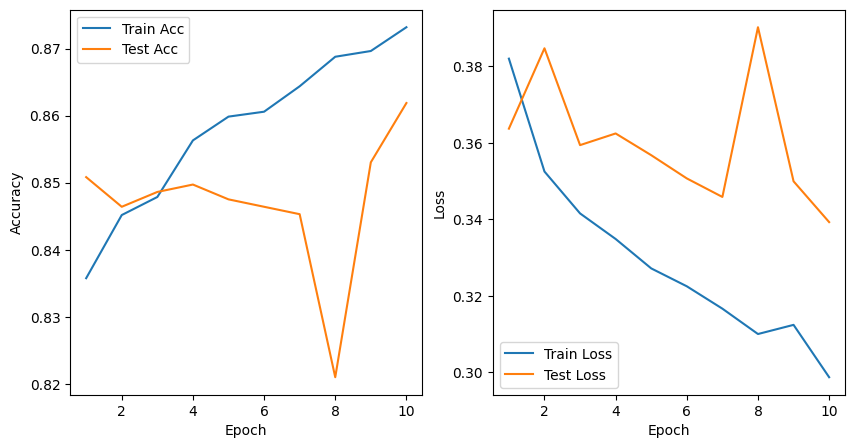

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history3["train_acc"]),
            ("Test Acc", cnn_model_train_history3["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history3["train_loss"]),
            ("Test Loss", cnn_model_train_history3["test_loss"])
        ]
    }
)

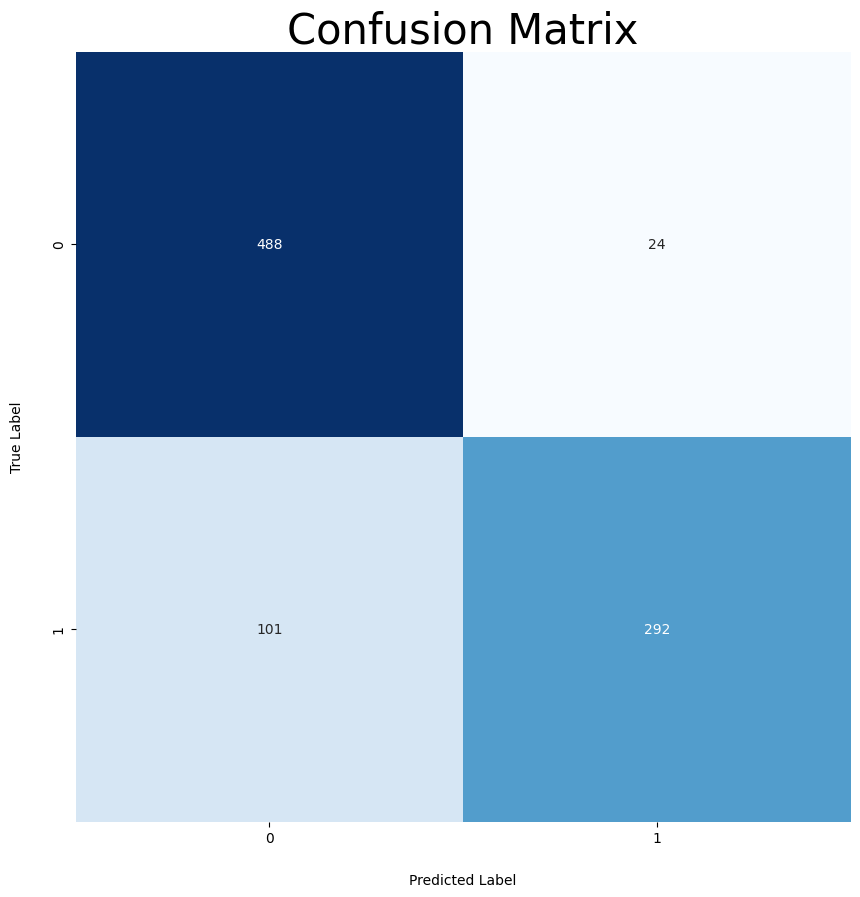

In [ ]:
cnn_model_report3 = generate_confusion_matrix(
    model=model_3,
    dataset=test_dataset,
)

In [ ]:
print(f"Recall:    {cnn_model_report3['recall']:.3f}")
print(f"F1:        {cnn_model_report3['f1']:.3f}")
print(f"Precision: {cnn_model_report3['precision']:.3f}")
print(cnn_model_report3['report'])

Recall:    0.848
F1:        0.855
Precision: 0.876
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       512
           1       0.92      0.74      0.82       393

    accuracy                           0.86       905
   macro avg       0.88      0.85      0.86       905
weighted avg       0.87      0.86      0.86       905



#### Comparision

**Regularization Impact:**
- **High Initial Performance**: Your model metrics were already high.
- **Slight Improvement**: Regularization methods like dropout, L2 regularization, and data augmentation slightly improved performance.

**Benefits of Regularization:**
1. **Prevent Overfitting**: Helps the model generalize better to unseen data.
2. **Increase Robustness**: Adds stability, making the model less sensitive to specific patterns.

Even with high initial metrics, regularization ensured better generalization and robustness, leading to a slight performance boost.

### Window-Context = 196 ; Regularization = True

In [ ]:
model_4 = CNN(196, reg=True)
batch_size = 32
num_epochs = 10

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_4.parameters(), lr=0.03)

# Training history
cnn_model_train_history4 = train_model(
    model=model_4,
    batch_size=batch_size,
    loss_function=criterion,
    optimizer=optimizer,
    epochs=num_epochs,
    train_set=train_dataset_2,
    test_set=test_dataset_2
)

(Eval): 100%|██████████| 29/29 [00:00<00:00, 64.68it/s, accuracy=0.852, loss=0.661]


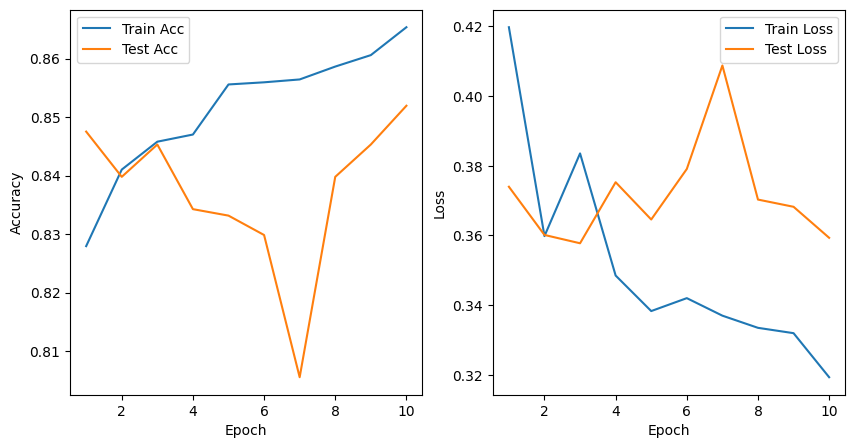

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history4["train_acc"]),
            ("Test Acc", cnn_model_train_history4["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history4["train_loss"]),
            ("Test Loss", cnn_model_train_history4["test_loss"])
        ]
    }
)

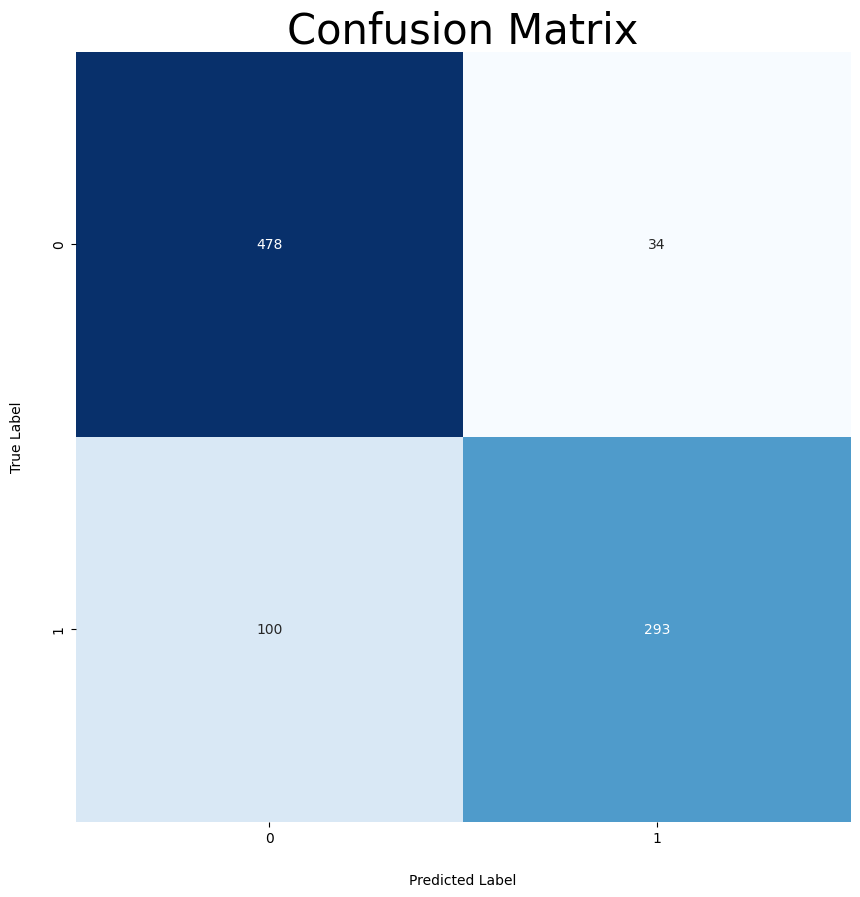

In [ ]:
cnn_model_report4 = generate_confusion_matrix(
    model=model_4,
    dataset=test_dataset_2,
)

In [ ]:
print(f"Recall:    {cnn_model_report4['recall']:.3f}")
print(f"F1:        {cnn_model_report4['f1']:.3f}")
print(f"Precision: {cnn_model_report4['precision']:.3f}")
print(cnn_model_report4['report'])

Recall:    0.840
F1:        0.845
Precision: 0.862
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       512
           1       0.90      0.75      0.81       393

    accuracy                           0.85       905
   macro avg       0.86      0.84      0.85       905
weighted avg       0.86      0.85      0.85       905



#### Comparision

Regularization methods, while generally beneficial, can sometimes lead to slight decreases in performance, particularly in scenarios with larger context windows. This may occur due to underfitting, data sparsity, interaction with learning rate, sensitivity to hyperparameters, and model complexity. Fine-tuning regularization parameters and considering interactions with other hyperparameters are crucial for optimizing performance.